<span style="color:#e74c3c;"> <b>Note:</b> There was a problem with categorical ids of the test annotation file. I adjusted this problem and uploaded the corrected file.[1] </span> 
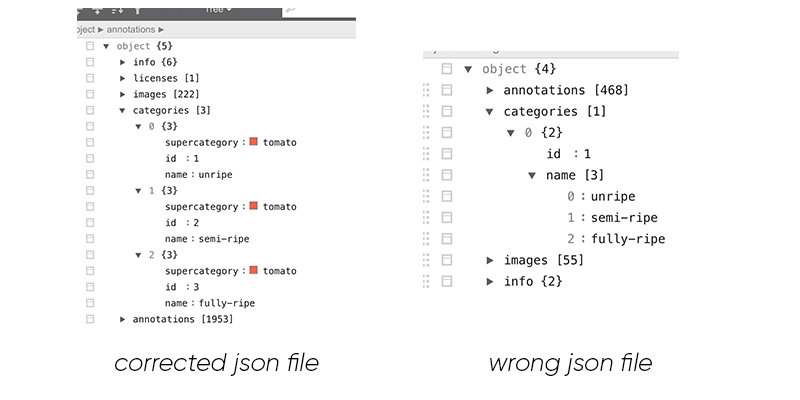


I have used the following methods.

* I used a pretrained <b>Faster R-CNN with ResNet-101 Region Proposal Network</b> from detectron2 [2,3]
* I have modified the official notebook [4]


## Test Set Predictions
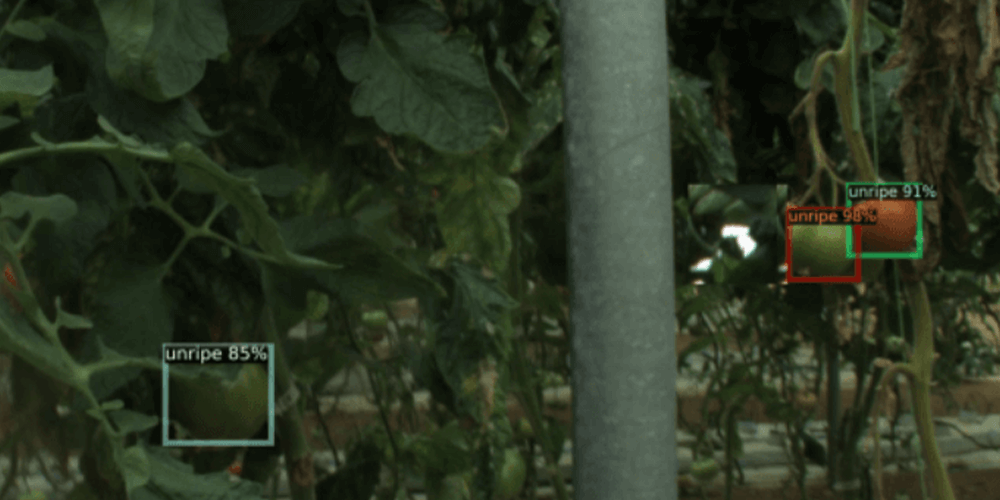
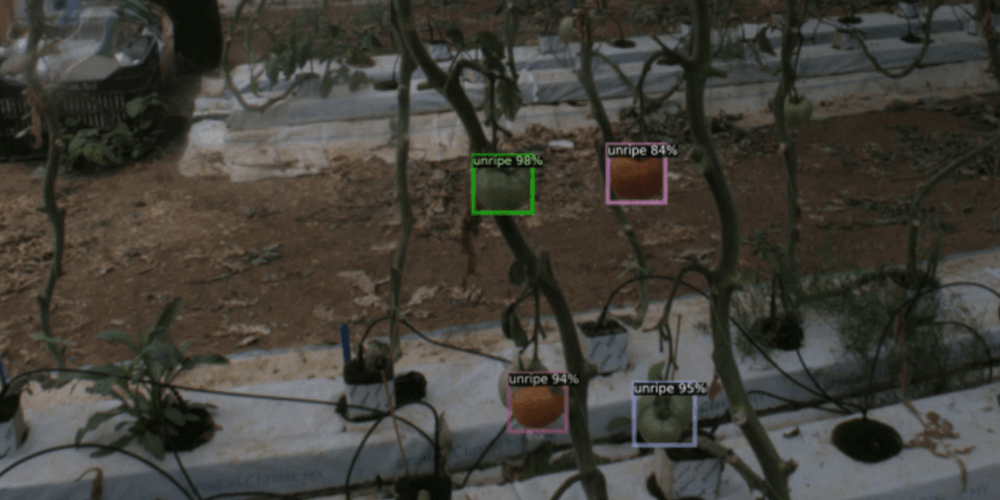

## References
1. https://www.kaggle.com/datasets/banddaniel/adjusted-tomato-od-test-json
2. Ren, S., He, K., Girshick, R., & Sun, J. (2015). Faster R-CNN: Towards Real-Time Object Detection with Region Proposal Networks (Version 3). arXiv. https://doi.org/10.48550/ARXIV.1506.01497
3. https://detectron2.readthedocs.io/en/latest/
4. https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

In [1]:
import sys, os, distutils.core
from IPython.display import clear_output

!python -m pip install pyyaml==5.1
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))
clear_output()

In [2]:
# Importing dependencies

import torch, detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
print("detectron2 version:", detectron2.__version__)

import numpy as np
import os, json, cv2, random
from IPython import display
import PIL
import matplotlib.pyplot as plt

# importing detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog


SEED = 10
THRESHOLD = 0.8

detectron2 version: 0.6


# <span style="color:#e74c3c;"> Creating </span> Datasets

In [3]:
# Creating coco instances

from detectron2.data.datasets import register_coco_instances
from detectron2.structures import BoxMode

    
register_coco_instances(f"tomato_dataset_train", {},
                        f"../input/tomatod/tomatOD_annotations/tomatOD_train.json",
                        f"../input/tomatod/tomatOD_images/train")

register_coco_instances(f"tomato_dataset_test", {},
                        f"../input/adjusted-tomato-od-test-json/ADJUSTED_tomatOD_test.json",
                        f"../input/tomatod/tomatOD_images/test")

In [4]:
# Examples from the training dataset

import random
from detectron2.utils.visualizer import Visualizer

my_dataset_train_metadata = MetadataCatalog.get("tomato_dataset_train")
train_dataset_dicts = DatasetCatalog.get("tomato_dataset_train")

# A function that creates examples from the dataset
def create_random_images(dataset_dict,dataset_metadata, seed, image_scale = 0.7):
    np.random.seed(seed)
    images = np.random.permutation(dataset_dict)[:2]
    
    fig, axs = plt.subplots(1,2, figsize = (12,6), dpi = 100)
    for i in range(2):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        vis = visualizer.draw_dataset_dict(im)
        final_img = vis.get_image()
        
        axs[i].set_title('image id: ' + str(img_id), fontsize = 10)
        axs[i].axis('off')
        axs[i].imshow(final_img)

[10/18 12:39:25 d2.data.datasets.coco]: Loaded 222 images in COCO format from ../input/tomatod/tomatOD_annotations/tomatOD_train.json


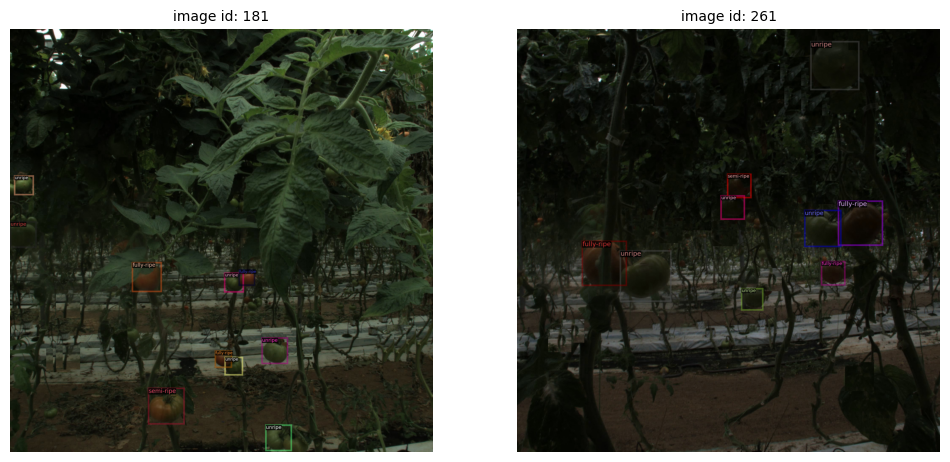

In [5]:
create_random_images(train_dataset_dicts, my_dataset_train_metadata, seed = 5, image_scale = 1)

# <span style="color:#e74c3c;"> Training </span>

In [6]:
from detectron2.engine import DefaultTrainer

EPOCHS = 2700
NUM_CLASSES = 3 
BASE_LR = 0.0001

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("tomato_dataset_train")
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")  
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = BASE_LR  
cfg.SOLVER.MAX_ITER = EPOCHS    
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = NUM_CLASSES

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

# uncomment below to train
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[10/18 12:39:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f6e8b1.pkl: 243MB [00:01, 204MB/s]                           


[10/18 12:39:33 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /usr/local/src/pytorch/aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[10/18 12:39:50 d2.utils.events]:  eta: 0:14:18  iter: 19  total_loss: 2.071  loss_cls: 1.28  loss_box_reg: 0.6473  loss_rpn_cls: 0.1073  loss_rpn_loc: 0.04816    time: 0.3216  last_time: 0.3197  data_time: 0.0269  last_data_time: 0.0100   lr: 1.9981e-06  max_mem: 2388M


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


[10/18 12:40:06 d2.utils.events]:  eta: 0:14:17  iter: 39  total_loss: 1.937  loss_cls: 1.24  loss_box_reg: 0.5842  loss_rpn_cls: 0.07129  loss_rpn_loc: 0.04146    time: 0.3707  last_time: 0.3672  data_time: 0.0103  last_data_time: 0.0169   lr: 3.9961e-06  max_mem: 2388M
[10/18 12:40:13 d2.utils.events]:  eta: 0:14:10  iter: 59  total_loss: 1.909  loss_cls: 1.177  loss_box_reg: 0.6302  loss_rpn_cls: 0.0827  loss_rpn_loc: 0.0418    time: 0.3516  last_time: 0.2498  data_time: 0.0127  last_data_time: 0.0050   lr: 5.9941e-06  max_mem: 2388M
[10/18 12:40:19 d2.utils.events]:  eta: 0:13:59  iter: 79  total_loss: 1.748  loss_cls: 1.086  loss_box_reg: 0.5745  loss_rpn_cls: 0.06603  loss_rpn_loc: 0.04084    time: 0.3402  last_time: 0.2799  data_time: 0.0080  last_data_time: 0.0064   lr: 7.9921e-06  max_mem: 2388M
[10/18 12:40:25 d2.utils.events]:  eta: 0:13:33  iter: 99  total_loss: 1.592  loss_cls: 0.9599  loss_box_reg: 0.5406  loss_rpn_cls: 0.05704  loss_rpn_loc: 0.03151    time: 0.3324  last

In [7]:
# Saving the model

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = THRESHOLD
predictor = DefaultPredictor(cfg)

import pickle
with open("cfg.pkl", "wb") as f:
    pickle.dump(cfg, f)

[10/18 12:54:03 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


# <span style="color:#e74c3c;"> Training </span> Results

In [8]:
# original code from https://eidos-ai.medium.com/training-on-detectron2-with-a-validation-set-and-plot-loss-on-it-to-avoid-overfitting-6449418fbf4e

def reading_metrics_from_json(metrics_path):
    metrics = []
    
    with open(metrics_path, 'r') as f:
        for line in f:
            metrics.append(json.loads(line))
    return metrics


def metric(metrics, specific_metric):
    metric = []
    for i in range(len(metrics)):
        metric.append(metrics[i][specific_metric])
    return metric

In [9]:
train_metrics = reading_metrics_from_json('/kaggle/working/output/metrics.json')

iters = metric(train_metrics, 'iteration')
total_loss = metric(train_metrics, 'total_loss')
cls_acc = metric(train_metrics, 'fast_rcnn/cls_accuracy')
false_neg = metric(train_metrics, 'fast_rcnn/false_negative')
loss_box_reg = metric(train_metrics, 'loss_box_reg')

Text(0.5, 1.0, 'False Negative')

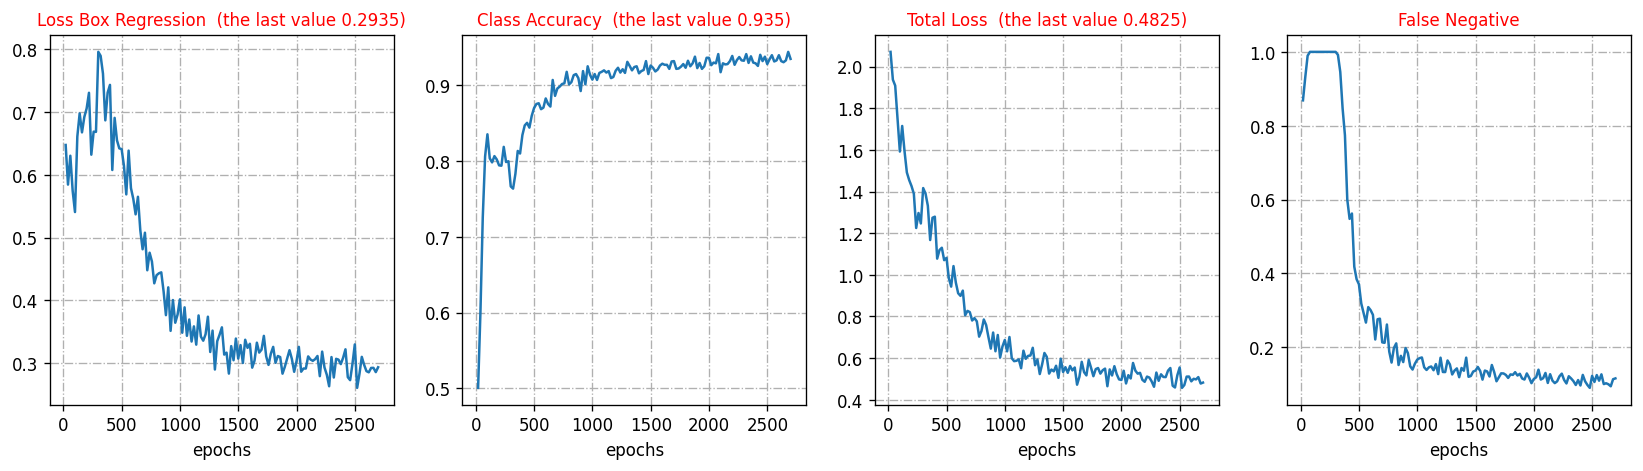

In [10]:
fig, axs = plt.subplots(1,4, figsize = (17, 4), dpi = 120)

axs[0].grid(linestyle = 'dashdot')
axs[0].plot(iters, loss_box_reg)
axs[0].set_xlabel('epochs', fontsize = 10)
axs[0].set_title('Loss Box Regression', fontsize = 10)
tit0 = ' (the last value {0:.4f})'.format(loss_box_reg[-1])
axs[0].set_title('Loss Box Regression ' + tit0, fontsize = 10, color = 'red')

axs[1].grid(linestyle = 'dashdot')
axs[1].plot(iters, cls_acc)
axs[1].set_xlabel('epochs', fontsize = 10)
tit1 = ' (the last value {0:.3f})'.format(cls_acc[-1])
axs[1].set_title('Class Accuracy ' + tit1, fontsize = 10, color = 'red')

axs[2].grid(linestyle = 'dashdot')
axs[2].plot(iters, total_loss)
axs[2].set_xlabel('epochs', fontsize = 10)
tit2 = ' (the last value {0:.4f})'.format(total_loss[-1])
axs[2].set_title('Total Loss ' + tit2, fontsize = 10, color = 'red')

axs[3].grid(linestyle = 'dashdot')
axs[3].plot(iters, false_neg)
axs[3].set_xlabel('epochs', fontsize = 10)
axs[3].set_title('False Negative', fontsize = 10, color = 'red')

# <span style="color:#e74c3c;"> Test </span> Predictions

In [11]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("tomato_dataset_test", False, output_dir="./output/")
test_loader = build_detection_test_loader(cfg, "tomato_dataset_test")
inference_on_dataset(trainer.model, test_loader, evaluator)

[10/18 12:54:04 d2.evaluation.coco_evaluation]: Fast COCO eval is not built. Falling back to official COCO eval.
[10/18 12:54:04 d2.data.datasets.coco]: Loaded 55 images in COCO format from ../input/adjusted-tomato-od-test-json/ADJUSTED_tomatOD_test.json
[10/18 12:54:04 d2.data.build]: Distribution of instances among all 3 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|   unripe   | 292          | semi-ripe  | 77           | fully-ripe | 99           |
|            |              |            |              |            |              |
|   total    | 468          |            |              |            |              |
[10/18 12:54:04 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[10/18 12:54:04 d2.data.common]: Serializing the datas

OrderedDict([('bbox',
              {'AP': 50.812998604961415,
               'AP50': 82.08385264854046,
               'AP75': 59.2675436258035,
               'APs': 35.38778877887789,
               'APm': 49.347631316878186,
               'APl': 54.594472084705835,
               'AP-unripe': 55.3382539831,
               'AP-semi-ripe': 41.854526007493455,
               'AP-fully-ripe': 55.2462158242908})])

In [12]:
my_dataset_test_metadata = MetadataCatalog.get("tomato_dataset_test")
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("tomato_dataset_test")


# A function for plotting an original image's bbox and predicted bbox
def create_predictions(dataset_dict, dataset_metadata, seed, image_scale = 0.8):
    np.random.seed(seed=seed)
    images = np.random.permutation(dataset_dict)[:3]
    
    fig, axs = plt.subplots(3,2, figsize = (20,20), dpi = 120)
    
    for i in range(3):
        im = images[i]
        img_link = im['file_name']
        img_id = im['image_id']
        img = cv2.imread(img_link)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        visualizer1 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)

        vis_original = visualizer1.draw_dataset_dict(im)
        original_bbox = vis_original.get_image()
        
        visualizer2 = Visualizer(img, metadata= dataset_metadata, scale=image_scale)
        outputs = predictor(img)
        out = visualizer2.draw_instance_predictions(outputs["instances"].to("cpu"))
        out_img = cv2.cvtColor(out.get_image(), cv2.COLOR_BGR2RGB)
        final_bbox = cv2.cvtColor(out_img, cv2.COLOR_BGR2RGB)
        
        axs[i][0].set_title('original bbox (id: ' + str(img_id) +')', fontsize = 20)
        axs[i][0].axis('off')
        axs[i][0].imshow(original_bbox)
        
        axs[i][1].set_title('predicted bbox (id: ' + str(img_id) +')', fontsize = 20, color = 'red')
        axs[i][1].axis('off')
        axs[i][1].imshow(final_bbox)
        
    fig.tight_layout()


[10/18 12:54:11 d2.data.datasets.coco]: Loaded 55 images in COCO format from ../input/adjusted-tomato-od-test-json/ADJUSTED_tomatOD_test.json


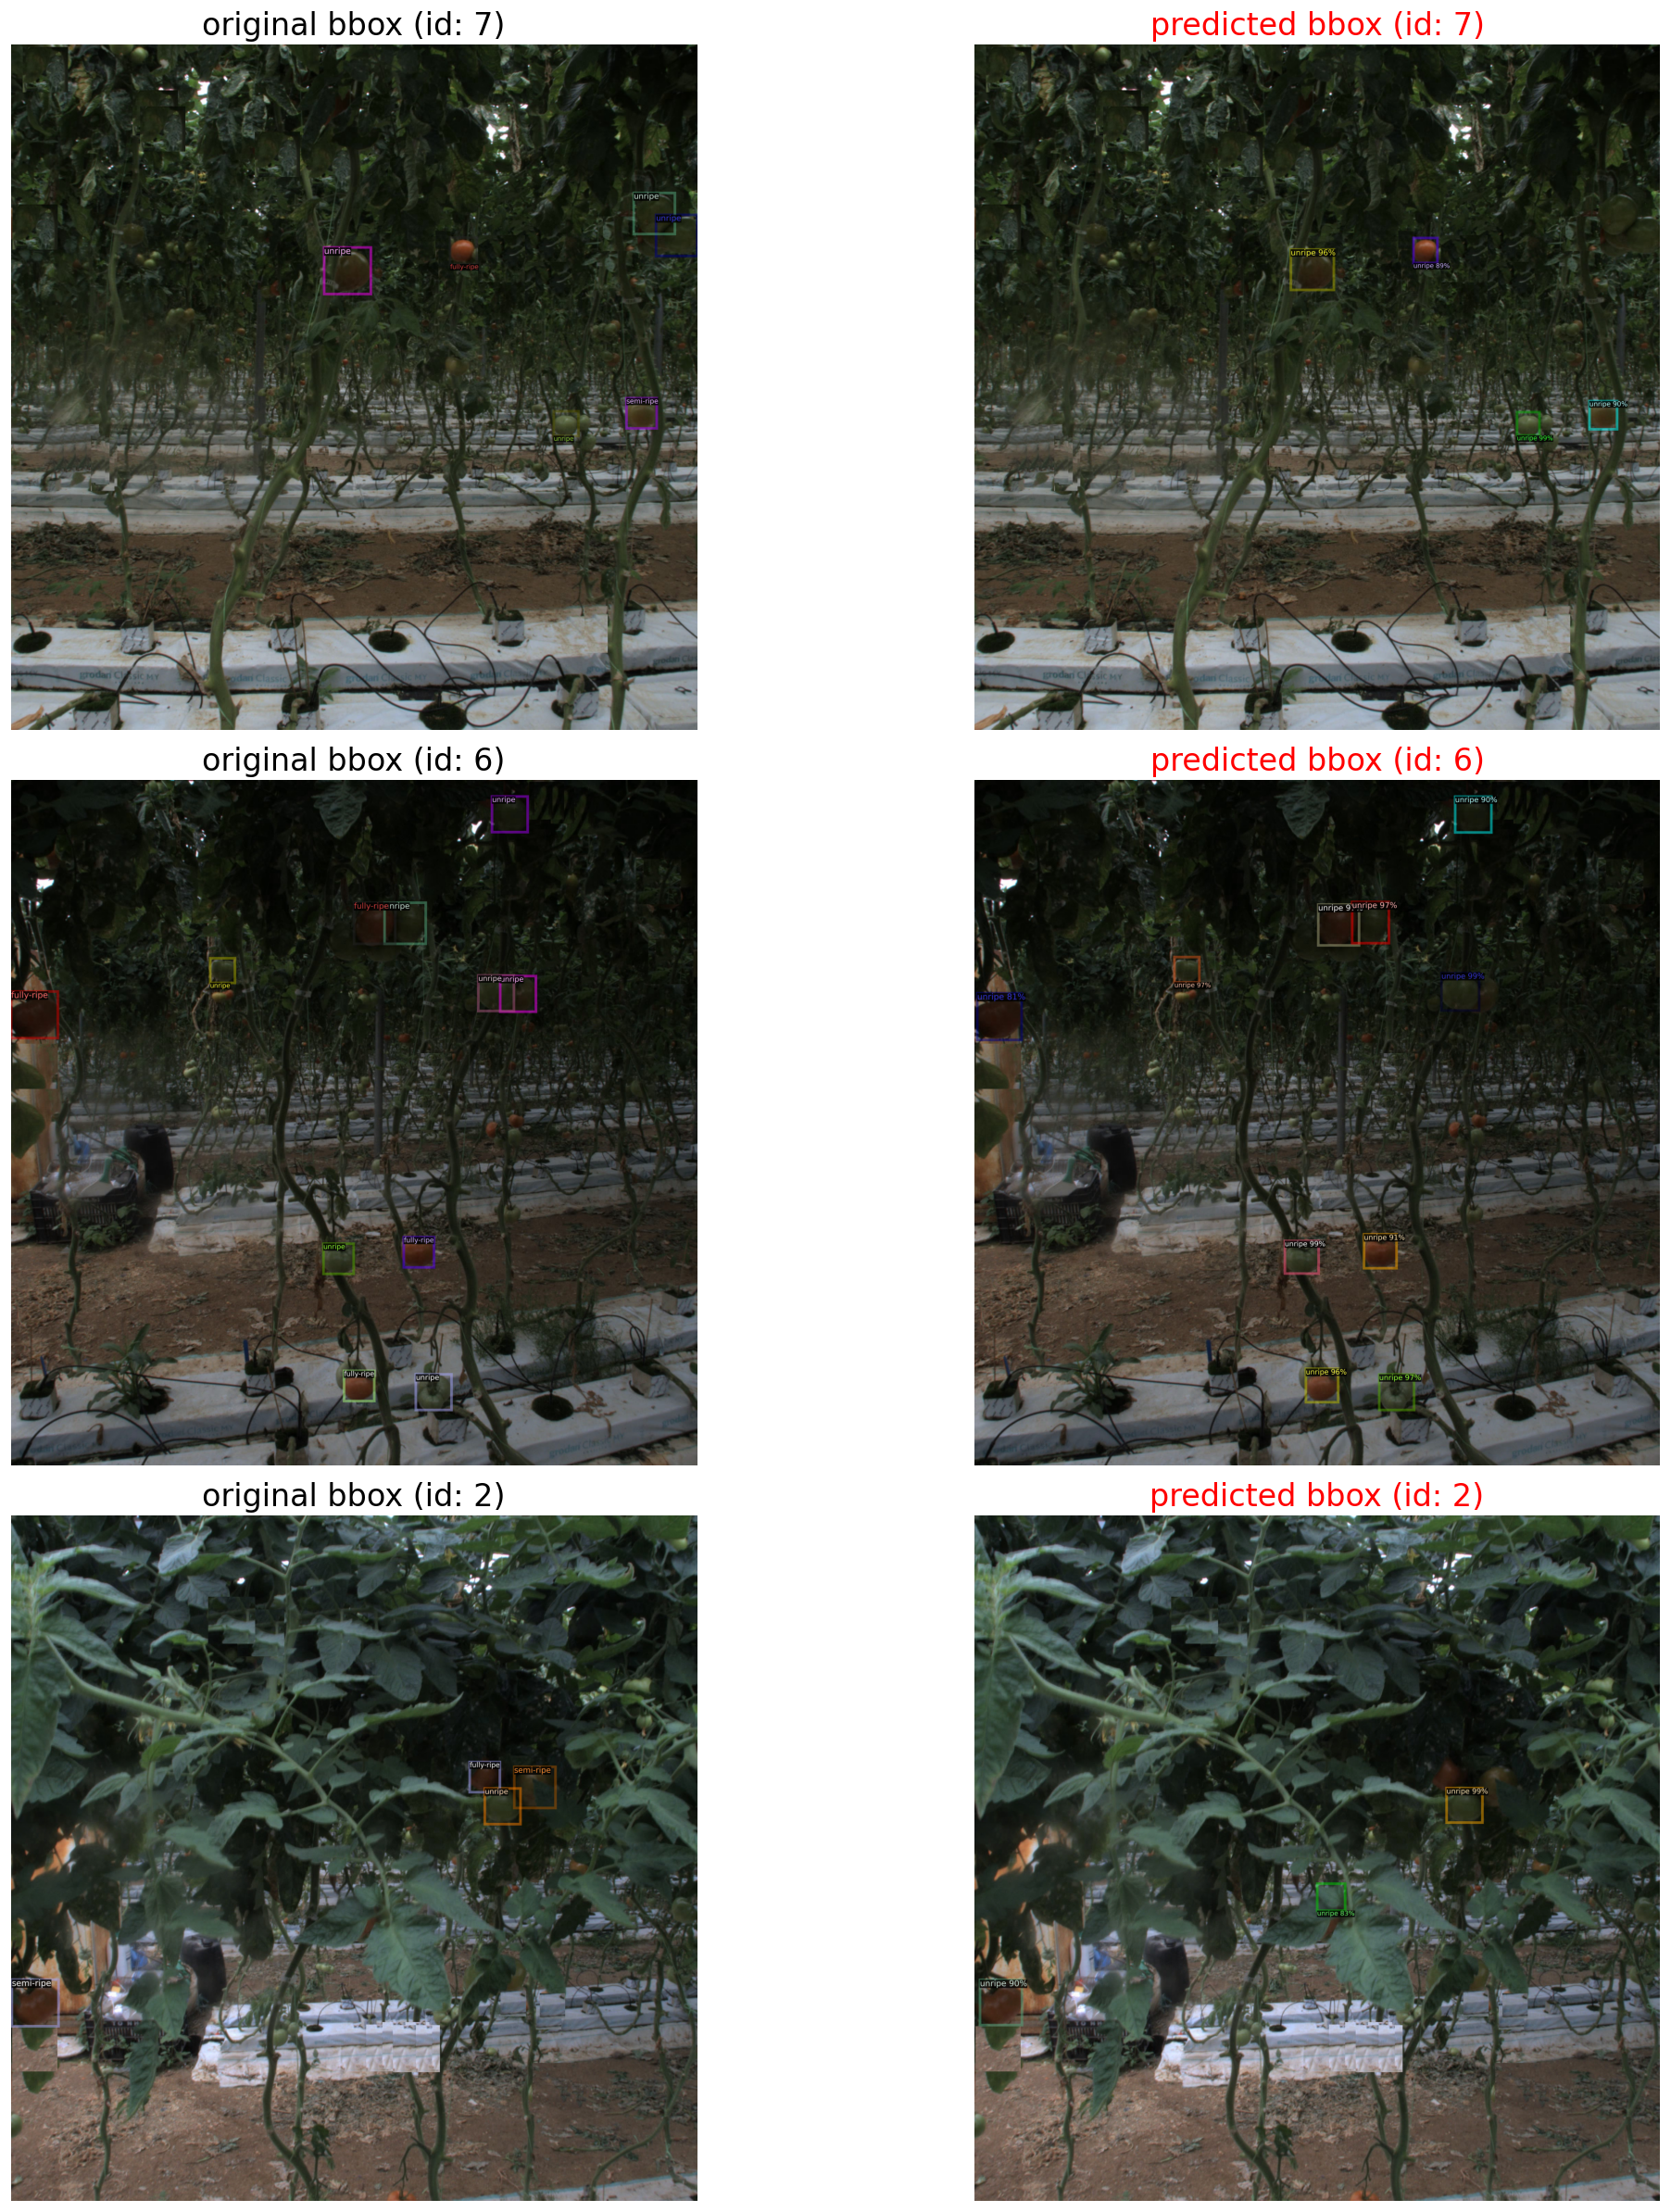

In [13]:
create_predictions(dataset_dicts,my_dataset_test_metadata,seed = 9, image_scale = 2)